# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

## Setup

In [1]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

## Random walks

### The data loader

In [5]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [6]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [7]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [8]:
idx

0

In [9]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [10]:
pos_rw

tensor([[2571, 1386, 2570,  ..., 2045,  603, 1873],
        [1105,  578, 1974,  ...,  711, 2111,  711],
        [ 476,  306,  112,  ..., 1013,   69, 2189],
        ...,
        [2056, 1841, 2056,  ...,  751,  736,  751],
        [ 333, 1358, 1620,  ...,  562,  704, 2113],
        [ 702, 2069, 1377,  ..., 2388,  175, 2388]])

In [11]:
neg_rw

tensor([[2571,  792, 2686,  ...,   12, 1023, 2007],
        [1105, 2425,  283,  ..., 2594, 1697, 1755],
        [ 476,  415,  554,  ..., 2019, 1847,  369],
        ...,
        [ 409,  421, 2600,  ..., 2259, 2601,  270],
        [  67, 1305, 1259,  ..., 2100, 1527, 2139],
        [2404,   79, 2390,  ..., 1455,  248, 2223]])

### Visualization

In [12]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

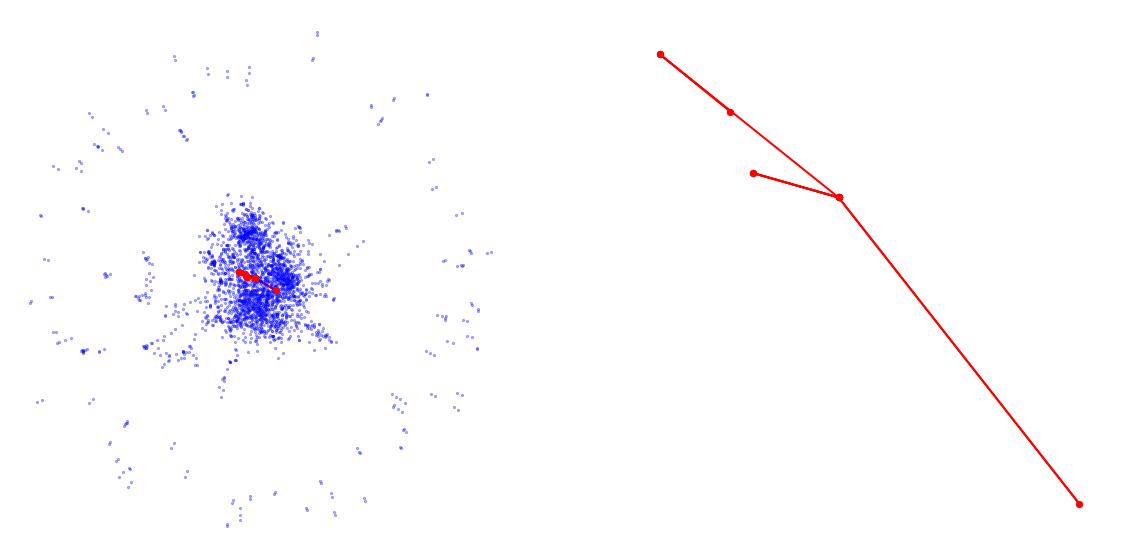

In [13]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

## Training

### Model definition

In [14]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [15]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [16]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [17]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [18]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [19]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

### Training

In [20]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.0718, Acc: 0.1460


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.0427, Acc: 0.1700


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.9415, Acc: 0.2070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.1228, Acc: 0.2420


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.4709, Acc: 0.2740


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.9523, Acc: 0.3100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.5429, Acc: 0.3370


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.2041, Acc: 0.3760


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.9471, Acc: 0.4130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.7284, Acc: 0.4430


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.5604, Acc: 0.4610


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.4219, Acc: 0.4850


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.3128, Acc: 0.5050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.2242, Acc: 0.5230


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.1563, Acc: 0.5340


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.1002, Acc: 0.5490


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.0553, Acc: 0.5660


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.0215, Acc: 0.5840


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.9915, Acc: 0.5950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.9686, Acc: 0.6130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.9492, Acc: 0.6250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.9332, Acc: 0.6340


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.9207, Acc: 0.6440


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.9103, Acc: 0.6570


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.9001, Acc: 0.6620


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.8923, Acc: 0.6650


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.8840, Acc: 0.6700


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.8794, Acc: 0.6700


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.8735, Acc: 0.6750


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.8683, Acc: 0.6800


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.8653, Acc: 0.6750


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.8623, Acc: 0.6790


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.8581, Acc: 0.6840


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.8556, Acc: 0.6880


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.8526, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.8505, Acc: 0.6870


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.8496, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.8468, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.8455, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.8439, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.8434, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.8420, Acc: 0.6960


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.8397, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.8397, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.8377, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.8364, Acc: 0.6950


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.8354, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.8353, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.8341, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.8340, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.8334, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.8327, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.8334, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.8317, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.8319, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.8311, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.8303, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.8290, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.8291, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.8287, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.8278, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.8281, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.8285, Acc: 0.6970


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.8285, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.8275, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.8281, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.8263, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.8275, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.8271, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.8278, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.8270, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.8257, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.8269, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.8239, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.8255, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.8261, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.8247, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.8260, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.8252, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.8261, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.8256, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.8258, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.8237, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.8250, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.8250, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.8249, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.8248, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.8244, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.8241, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.8243, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.8248, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.8244, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.8254, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.8256, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.8248, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.8237, Acc: 0.6890


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.8251, Acc: 0.6930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.8250, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.8246, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.8245, Acc: 0.6910


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.8237, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.8237, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.8226, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.8243, Acc: 0.6820


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.8245, Acc: 0.6870


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.8245, Acc: 0.6910


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.8254, Acc: 0.6940


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.8256, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.8237, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.8236, Acc: 0.6880


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.8244, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.8238, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.8236, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.8248, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.8234, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.8246, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.8244, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.8249, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.8254, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.8236, Acc: 0.7170


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.8235, Acc: 0.7200


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.8243, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.8251, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.8236, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.8244, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.8249, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.8237, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.8256, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.8236, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.8241, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.8238, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.8248, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.8241, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.8239, Acc: 0.7210


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.8235, Acc: 0.7230


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.8252, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.8252, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.8236, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.8236, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.8235, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.8245, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.8249, Acc: 0.6900


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.8239, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.8246, Acc: 0.7000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.8248, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.8235, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.8238, Acc: 0.6990


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.8234, Acc: 0.6920


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.8241, Acc: 0.7020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 150, Loss: 0.8253, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 151, Loss: 0.8250, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 152, Loss: 0.8249, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 153, Loss: 0.8262, Acc: 0.7010


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 154, Loss: 0.8248, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 155, Loss: 0.8241, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 156, Loss: 0.8244, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 157, Loss: 0.8255, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 158, Loss: 0.8251, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 159, Loss: 0.8245, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 160, Loss: 0.8243, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 161, Loss: 0.8247, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 162, Loss: 0.8247, Acc: 0.7090


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 163, Loss: 0.8243, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 164, Loss: 0.8242, Acc: 0.7190


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 165, Loss: 0.8252, Acc: 0.7170


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 166, Loss: 0.8250, Acc: 0.7110


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 167, Loss: 0.8252, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 168, Loss: 0.8254, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 169, Loss: 0.8250, Acc: 0.7170


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 170, Loss: 0.8247, Acc: 0.7190


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 171, Loss: 0.8236, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 172, Loss: 0.8246, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 173, Loss: 0.8243, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 174, Loss: 0.8249, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 175, Loss: 0.8253, Acc: 0.7070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 176, Loss: 0.8250, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 177, Loss: 0.8245, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 178, Loss: 0.8251, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 179, Loss: 0.8255, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 180, Loss: 0.8247, Acc: 0.7260


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 181, Loss: 0.8257, Acc: 0.7220


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 182, Loss: 0.8251, Acc: 0.7120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 183, Loss: 0.8243, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 184, Loss: 0.8242, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 185, Loss: 0.8255, Acc: 0.7160


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 186, Loss: 0.8256, Acc: 0.7130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 187, Loss: 0.8249, Acc: 0.7040


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 188, Loss: 0.8255, Acc: 0.7030


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 189, Loss: 0.8249, Acc: 0.7150


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 190, Loss: 0.8259, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 191, Loss: 0.8257, Acc: 0.7060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 192, Loss: 0.8254, Acc: 0.7100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 193, Loss: 0.8246, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 194, Loss: 0.8255, Acc: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 195, Loss: 0.8241, Acc: 0.7050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 196, Loss: 0.8250, Acc: 0.7150


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 197, Loss: 0.8246, Acc: 0.7080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 198, Loss: 0.8234, Acc: 0.7140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 199, Loss: 0.8251, Acc: 0.7210


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 200, Loss: 0.8255, Acc: 0.7220


### Visualization

/home/user/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/user/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


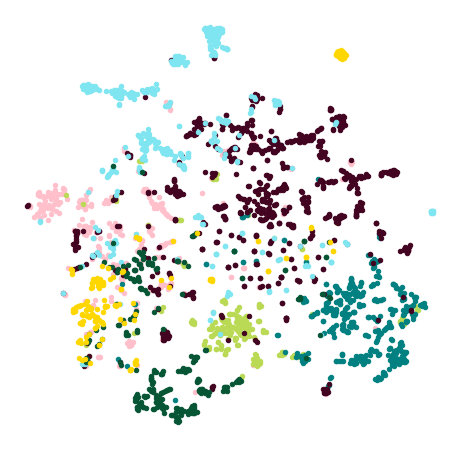

In [21]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)